In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/VOCtrainval_11-May-2012.tar .
!tar -xvf 'VOCtrainval_11-May-2012.tar'

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

In [ ]:
import pandas as pd
train_data = pd.read_csv("/content/trainData_final.csv",sep='^',index_col=[0])
train_data.head()
som_data = train_data[train_data['label']=='person'][:500].copy(deep=True)
train_data = train_data[train_data['label']!='person']
train_data = train_data.append(som_data)

test_data = pd.read_csv("/content/testData.csv",sep='^',index_col=[0])
som_data = test_data[test_data['label']=='person'][:500].copy(deep=True)
test_data = test_data[test_data['label']!='person']
test_data = test_data.append(som_data)


In [ ]:
train_data = train_data.sample(frac =1)
test_data = test_data.sample(frac =1)
len(train_data)

7558

In [ ]:
import cv2
from tqdm import tqdm
import numpy as np
train_x = []
for row in tqdm(train_data.iterrows(),position=0,leave=True):
  # print(row[1]['name'])
  train_x.append(cv2.resize(cv2.imread("/content/VOCdevkit/VOC2012/JPEGImages/"+row[1]['filename']+".jpg"),(100,100)))
  # print(train_x)

7558it [00:42, 179.73it/s]


In [ ]:
import cv2
from tqdm import tqdm
import numpy as np
test_x = []
for row in tqdm(test_data.iterrows(),position=0,leave=True):
  # print(row[1]['name'])
  test_x.append(cv2.resize(cv2.imread("/content/VOCdevkit/VOC2012/JPEGImages/"+row[1]['filename']+".jpg"),(100,100)))
  # print(train_x)

7580it [00:41, 180.62it/s]


In [ ]:
train_x = np.array(train_x).reshape(len(train_data),30000)
test_x = np.array(test_x).reshape(len(test_data),30000)

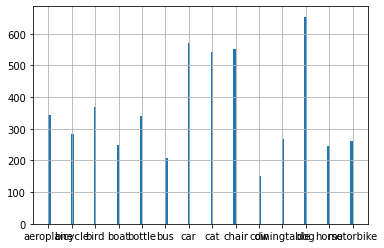

In [ ]:
test_dataf['label'].hist(bins=120)

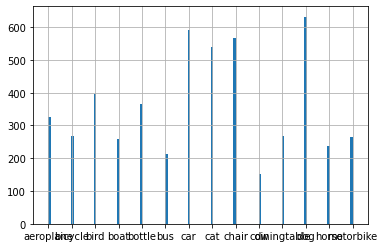

In [ ]:
traindataf['label'].hist(bins=120)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
a,b = train_x.shape
train_x = train_x.reshape((a,100,100,3))
model = VGG16(weights='imagenet', include_top=False,input_shape=(100,100,3))


x = preprocess_input(train_x)

features_y = model.predict(x)
train_data_cnn = features_y


58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
a,b = test_dataf_cop.shape
test_dataf_cop = test_dataf_cop.reshape((a,100,100,3))
model = VGG16(weights='imagenet', include_top=False,input_shape=(100,100,3))


x = preprocess_input(test_dataf_cop)

features_y = model.predict(x)
test_data_cnn = features_y


In [ ]:
train_data_cnn = train_data_cnn.reshape(len(train_data_cnn),512*9)
traindataf = pd.DataFrame(train_data_cnn,columns = np.arange(1,train_data_cnn.shape[1]+1))
traindataf['label'] = train_data['label'][:len(train_data_cnn)].reset_index(drop=True)

In [ ]:
test_data_cnn = test_data_cnn.reshape(len(test_data_cnn),512*9)
test_dataf = pd.DataFrame(test_data_cnn,columns = np.arange(1,test_data_cnn.shape[1]+1))
test_dataf['label'] = test_data['label'][:len(test_data_cnn)].reset_index(drop=True)

In [ ]:
from sklearn.svm import SVC
import math
import numpy as np
def algo2(train_data,n2,q,N,T):
  D0 = train_data.sample(n=N)
  # print(np.array(D0.drop('Label',axis=1)).shape)
  # print(np.array(D0['Label']).shape)
  g0 = SVC(probability=True,kernel='rbf').fit(D0.drop('label',axis=1),D0['label'])
  # print(g0.decision_function(train_data.sample().drop('Label',axis=1)))
  z  = train_data.sample()
  z1  = z
  t = 1
  while(t<=T):
    i=1
    n1=0
    D = []
    while(i<=N):
      z_ = train_data.sample()
      # print(g0.decision_function(np.array(z_.drop('Label',axis=1))).shape)
      p = min(1,np.exp(-(g0.decision_function(np.array(z_.drop('label',axis=1)).reshape(1,512*9))).max())/np.exp(-(g0.decision_function(np.array(z1.drop('label',axis=1)).reshape(1,512*9))).max()))
      if(n1>n2):
        p = min(1,q*p)
        z1 = z_
        D.append(z1)
        i=i+1
        n1=0
      # print(p)
      # print(np.array(z_['Label']))
      if(p==1 and z_['label'].iloc[0]==z1['label'].iloc[0]):
        z_pred = 2*((g0.predict(np.array(z_.drop('label',axis=1)).reshape(1,512*9))[0]==z_['label'].iloc[0])-0.5)
        z1pred = 2*((g0.predict(np.array(z1.drop('label',axis=1)).reshape(1,512*9))[0]==z1['label'].iloc[0])-0.5)
        # print(z_pred[0])
        p = np.exp(-(z_pred))/np.exp(-(z1pred))
      if(np.random.rand(1)<p):
        z1 = z_
        D.append(z1)
        i+=1
        n1=0
      if(p<0.6):
        n1+=1
      # print("k")
    Dt = pd.concat(D)
    g0 = SVC(probability=True,kernel='rbf').fit(Dt.drop('label',axis=1),Dt['label'])
    arr = g0.predict(Dt.drop('label',axis=1))==Dt['label']
    e=0
    for i in arr:
      if(i):
        e+=1

    e/=len(arr)
    # e = g0.predict_proba(np.array(z1.drop('Label',axis=1)).reshape(1,16))
    alpha = 0.5*math.log((1-e)/e)
    z1 = z_
    t+=1
    # if(alpha<0):
    #   t-=1
    # print(t)
  return g0

model = algo2(traindataf,5,2,1000,10)
    


In [ ]:
pred = model.predict(test_dataf.drop('label',axis=1))
from sklearn.metrics import classification_report
print(classification_report(test_dataf['label'],pred))

              precision    recall  f1-score   support

   aeroplane       0.62      0.49      0.55        51
     bicycle       0.60      0.09      0.16        32
        bird       0.75      0.39      0.51        46
        boat       0.50      0.13      0.21        30
      bottle       0.00      0.00      0.00        47
         bus       0.58      0.20      0.30        35
         car       0.46      0.37      0.41        79
         cat       0.69      0.42      0.52        69
       chair       0.32      0.34      0.33        74
         cow       0.00      0.00      0.00        17
 diningtable       0.00      0.00      0.00        45
         dog       0.34      0.46      0.39        78
       horse       0.00      0.00      0.00        35
   motorbike       0.82      0.23      0.36        39
      person       0.30      0.86      0.44       212
 pottedplant       0.00      0.00      0.00        29
       sheep       0.00      0.00      0.00        16
        sofa       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.svm import SVC
import math
import numpy as np
def algo2(train_data,n2,q,N,T):
  D0 = train_data.sample(n=N)
  # print(np.array(D0.drop('Label',axis=1)).shape)
  # print(np.array(D0['Label']).shape)
  g0 = SVC(probability=True,kernel='poly').fit(D0.drop('label',axis=1),D0['label'])
  # print(g0.decision_function(train_data.sample().drop('Label',axis=1)))
  z  = train_data.sample()
  z1  = z
  t = 1
  while(t<=T):
    i=1
    n1=0
    D = []
    while(i<=N):
      z_ = train_data.sample()
      # print(g0.decision_function(np.array(z_.drop('Label',axis=1))).shape)
      p = min(1,np.exp(-(g0.decision_function(np.array(z_.drop('label',axis=1)).reshape(1,512*9))).max())/np.exp(-(g0.decision_function(np.array(z1.drop('label',axis=1)).reshape(1,512*9))).max()))
      if(n1>n2):
        p = min(1,q*p)
        z1 = z_
        D.append(z1)
        i=i+1
        n1=0
      # print(p)
      # print(np.array(z_['Label']))
      if(p==1 and z_['label'].iloc[0]==z1['label'].iloc[0]):
        z_pred = 2*((g0.predict(np.array(z_.drop('label',axis=1)).reshape(1,512*9))[0]==z_['label'].iloc[0])-0.5)
        z1pred = 2*((g0.predict(np.array(z1.drop('label',axis=1)).reshape(1,512*9))[0]==z1['label'].iloc[0])-0.5)
        # print(z_pred[0])
        p = np.exp(-(z_pred))/np.exp(-(z1pred))
      if(np.random.rand(1)<p):
        z1 = z_
        D.append(z1)
        i+=1
        n1=0
      if(p<0.6):
        n1+=1
      # print("k")
    Dt = pd.concat(D)
    g0 = SVC(probability=True,kernel='poly').fit(Dt.drop('label',axis=1),Dt['label'])
    arr = g0.predict(Dt.drop('label',axis=1))==Dt['label']
    e=0
    for i in arr:
      if(i):
        e+=1

    e/=len(arr)
    # e = g0.predict_proba(np.array(z1.drop('Label',axis=1)).reshape(1,16))
    alpha = 0.5*math.log((1-e)/e)
    z1 = z_
    t+=1
    # if(alpha<0):
    #   t-=1
    # print(t)
  return g0

model = algo2(traindataf,5,2,1000,10)
    


In [ ]:
pred = model.predict(test_dataf.drop('label',axis=1))
from sklearn.metrics import classification_report
print(classification_report(test_dataf['label'],pred))

              precision    recall  f1-score   support

   aeroplane       0.78      0.14      0.23        51
     bicycle       0.33      0.06      0.11        32
        bird       1.00      0.02      0.04        46
        boat       0.00      0.00      0.00        30
      bottle       0.00      0.00      0.00        47
         bus       0.00      0.00      0.00        35
         car       0.75      0.04      0.07        79
         cat       0.50      0.30      0.38        69
       chair       0.00      0.00      0.00        74
         cow       0.00      0.00      0.00        17
 diningtable       0.00      0.00      0.00        45
         dog       0.64      0.12      0.20        78
       horse       0.17      0.03      0.05        35
   motorbike       0.86      0.15      0.26        39
      person       0.23      0.97      0.37       212
 pottedplant       0.00      0.00      0.00        29
       sheep       0.50      0.06      0.11        16
        sofa       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.svm import SVC
import math
import numpy as np
def algo2(train_data,n2,q,N,T):
  D0 = train_data.sample(n=N)
  # print(np.array(D0.drop('Label',axis=1)).shape)
  # print(np.array(D0['Label']).shape)
  g0 = SVC(probability=True,kernel='linear').fit(D0.drop('label',axis=1),D0['label'])
  # print(g0.decision_function(train_data.sample().drop('Label',axis=1)))
  z  = train_data.sample()
  z1  = z
  t = 1
  while(t<=T):
    i=1
    n1=0
    D = []
    while(i<=N):
      z_ = train_data.sample()
      # print(g0.decision_function(np.array(z_.drop('Label',axis=1))).shape)
      p = min(1,np.exp(-(g0.decision_function(np.array(z_.drop('label',axis=1)).reshape(1,512*9))).max())/np.exp(-(g0.decision_function(np.array(z1.drop('label',axis=1)).reshape(1,512*9))).max()))
      if(n1>n2):
        p = min(1,q*p)
        z1 = z_
        D.append(z1)
        i=i+1
        n1=0
      # print(p)
      # print(np.array(z_['Label']))
      if(p==1 and z_['label'].iloc[0]==z1['label'].iloc[0]):
        z_pred = 2*((g0.predict(np.array(z_.drop('label',axis=1)).reshape(1,512*9))[0]==z_['label'].iloc[0])-0.5)
        z1pred = 2*((g0.predict(np.array(z1.drop('label',axis=1)).reshape(1,512*9))[0]==z1['label'].iloc[0])-0.5)
        # print(z_pred[0])
        p = np.exp(-(z_pred))/np.exp(-(z1pred))
      if(np.random.rand(1)<p):
        z1 = z_
        D.append(z1)
        i+=1
        n1=0
      if(p<0.6):
        n1+=1
      # print("k")
    Dt = pd.concat(D)
    g0 = SVC(probability=True,kernel='linear').fit(Dt.drop('label',axis=1),Dt['label'])
    arr = g0.predict(Dt.drop('label',axis=1))==Dt['label']
    e=0
    for i in arr:
      if(i):
        e+=1

    e/=len(arr)
    # e = g0.predict_proba(np.array(z1.drop('Label',axis=1)).reshape(1,16))
    alpha = 0.5*math.log((1-e)/e)
    z1 = z_
    t+=1
    # if(alpha<0):
    #   t-=1
    # print(t)
  return g0

model = algo2(traindataf,5,2,1000,10)
    


In [ ]:
pred = model.predict(test_dataf.drop('label',axis=1))
from sklearn.metrics import classification_report
print(classification_report(test_dataf['label'],pred))

              precision    recall  f1-score   support

   aeroplane       0.72      0.75      0.73        51
     bicycle       0.41      0.38      0.39        32
        bird       0.67      0.43      0.53        46
        boat       0.39      0.37      0.38        30
      bottle       0.26      0.15      0.19        47
         bus       0.46      0.37      0.41        35
         car       0.44      0.34      0.39        79
         cat       0.51      0.67      0.58        69
       chair       0.26      0.36      0.31        74
         cow       0.23      0.18      0.20        17
 diningtable       0.41      0.20      0.27        45
         dog       0.40      0.45      0.42        78
       horse       0.41      0.26      0.32        35
   motorbike       0.59      0.26      0.36        39
      person       0.37      0.58      0.45       212
 pottedplant       0.25      0.07      0.11        29
       sheep       0.50      0.38      0.43        16
        sofa       0.18    

In [ ]:
from sklearn.svm import SVC
import math
import numpy as np
def algo2(train_data,n2,q,N,T):
  D0 = train_data.sample(n=N)
  # print(np.array(D0.drop('Label',axis=1)).shape)
  # print(np.array(D0['Label']).shape)
  g0 = SVC(probability=True,kernel='sigmoid').fit(D0.drop('label',axis=1),D0['label'])
  # print(g0.decision_function(train_data.sample().drop('Label',axis=1)))
  z  = train_data.sample()
  z1  = z
  t = 1
  while(t<=T):
    i=1
    n1=0
    D = []
    while(i<=N):
      z_ = train_data.sample()
      # print(g0.decision_function(np.array(z_.drop('Label',axis=1))).shape)
      p = min(1,np.exp(-(g0.decision_function(np.array(z_.drop('label',axis=1)).reshape(1,512*9))).max())/np.exp(-(g0.decision_function(np.array(z1.drop('label',axis=1)).reshape(1,512*9))).max()))
      if(n1>n2):
        p = min(1,q*p)
        z1 = z_
        D.append(z1)
        i=i+1
        n1=0
      # print(p)
      # print(np.array(z_['Label']))
      if(p==1 and z_['label'].iloc[0]==z1['label'].iloc[0]):
        z_pred = 2*((g0.predict(np.array(z_.drop('label',axis=1)).reshape(1,512*9))[0]==z_['label'].iloc[0])-0.5)
        z1pred = 2*((g0.predict(np.array(z1.drop('label',axis=1)).reshape(1,512*9))[0]==z1['label'].iloc[0])-0.5)
        # print(z_pred[0])
        p = np.exp(-(z_pred))/np.exp(-(z1pred))
      if(np.random.rand(1)<p):
        z1 = z_
        D.append(z1)
        i+=1
        n1=0
      if(p<0.6):
        n1+=1
      # print("k")
    Dt = pd.concat(D)
    g0 = SVC(probability=True,kernel='sigmoid').fit(Dt.drop('label',axis=1),Dt['label'])
    arr = g0.predict(Dt.drop('label',axis=1))==Dt['label']
    e=0
    for i in arr:
      if(i):
        e+=1

    e/=len(arr)
    # e = g0.predict_proba(np.array(z1.drop('Label',axis=1)).reshape(1,16))
    alpha = 0.5*math.log((1-e)/e)
    z1 = z_
    t+=1
    # if(alpha<0):
    #   t-=1
    # print(t)
  return g0

model = algo2(traindataf,5,2,1000,10)
    


In [ ]:
pred = model.predict(test_dataf.drop('label',axis=1))
from sklearn.metrics import classification_report
print(classification_report(test_dataf['label'],pred))

              precision    recall  f1-score   support

   aeroplane       0.70      0.73      0.71        51
     bicycle       0.00      0.00      0.00        32
        bird       0.79      0.33      0.46        46
        boat       0.00      0.00      0.00        30
      bottle       0.20      0.02      0.04        47
         bus       0.64      0.40      0.49        35
         car       0.54      0.32      0.40        79
         cat       0.56      0.64      0.60        69
       chair       0.67      0.03      0.05        74
         cow       0.00      0.00      0.00        17
 diningtable       0.00      0.00      0.00        45
         dog       0.47      0.46      0.46        78
       horse       0.30      0.17      0.22        35
   motorbike       1.00      0.05      0.10        39
      person       0.28      0.85      0.42       212
 pottedplant       0.00      0.00      0.00        29
       sheep       0.00      0.00      0.00        16
        sofa       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
